In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator, UnivariateSpline
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy
import seaborn as sns
from matplotlib.lines import Line2D
import math

In [216]:
folder_dir = '/Users/ziyuhe/Library/CloudStorage/OneDrive-UCSanDiego/Data/Financial Data/Green Bond'
bonds = pd.read_csv(f'{folder_dir}/bonds.csv')

In [297]:
def interpolate(x, y, color, size, label_prefix):
    k = min(3, max(len(x) - 3, 1))
    spl = UnivariateSpline(x, y, s=10000, k=k)
    xs = np.linspace(x.min(), x.max(), 100)
    
    # Using seaborn style
    sns.set(style="whitegrid")
    
    # Scatter plot
    ax.scatter(x, y, color=color, s=size, alpha=0.6, label=f'{label_prefix} Bonds')
    
    # Spline plot
    ax.plot(xs, spl(xs), color=color, lw=2, alpha=0.6)
    
    return spl

def interpolate_and_plot(bonds, ax, greenium):
    # Sorting values by 'Years to Maturity' for interpolation purposes
    green_bonds = bonds[bonds['Green'] == 1]
    nongreen_bonds = bonds[bonds['Green'] == 0]
    
    # Extracting x, y values and size for interpolation
    gx = green_bonds['Years to Maturity'].to_numpy()
    gy = green_bonds['Z Spread'].to_numpy()
    ngx = nongreen_bonds['Years to Maturity'].to_numpy()
    ngy = nongreen_bonds['Z Spread'].to_numpy()
    
    xrange = (0, math.floor(max(bonds['Years to Maturity'])) + 2)
    
    maxsize = max(bonds['Size'].to_numpy())
    
    # Normalize size for visualization purposes
    gsize = green_bonds['Size'].to_numpy()
    gsize = gsize / maxsize * 800
    ngsize = nongreen_bonds['Size'].to_numpy()
    ngsize = ngsize / maxsize * 800
    
    gspl = interpolate(gx, gy, 'green', gsize, 'Green')
    ngspl = interpolate(ngx, ngy, 'grey', ngsize, 'Conventional')
    
    # Labels and legend
    ax.set_xlabel('Years to Maturity')
    ax.set_ylabel('Z-Spread (bps)')
    
    ax.set_xlim(xrange)
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Green Bonds',
               markerfacecolor='green', markersize=np.sqrt(60), linestyle='None'),
        Line2D([0], [0], marker='o', color='w', label='Conventional Bonds',
               markerfacecolor='grey', markersize=np.sqrt(60), linestyle='None')
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    

    
    for index, row in green_bonds.iterrows():
        ttm = row['Years to Maturity']
        if (ttm >= min(ngx)) & (ttm <= max(ngx)):
            pred_z = ngspl(ttm)
            premium = row['Z Spread'] - pred_z
            greenium.append([row['Bond Name'], row['Country'], row['Company'], row['Coupon'], premium])
        
    return greenium

In [298]:
# Convert date strings to datetime objects
date_format = "%m/%d/%y"
bonds['Date'] = pd.to_datetime(bonds['Date'] , format=date_format)
bonds['Maturity Date'] = pd.to_datetime(bonds['Maturity Date'] , format=date_format)
bonds['Issue Date'] = pd.to_datetime(bonds['Issue Date'], format=date_format)
bonds['Years to Maturity'] = (bonds['Maturity Date'] - bonds['Date']).dt.days / 365.25

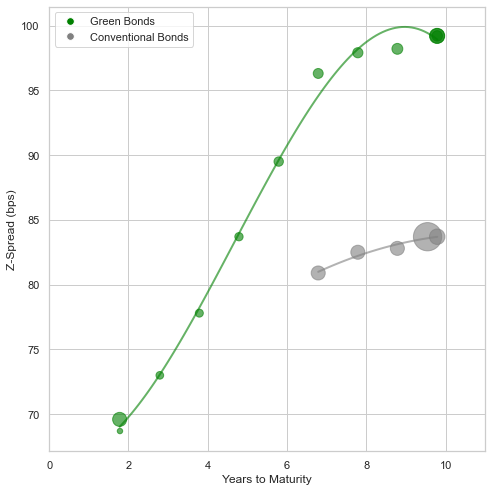

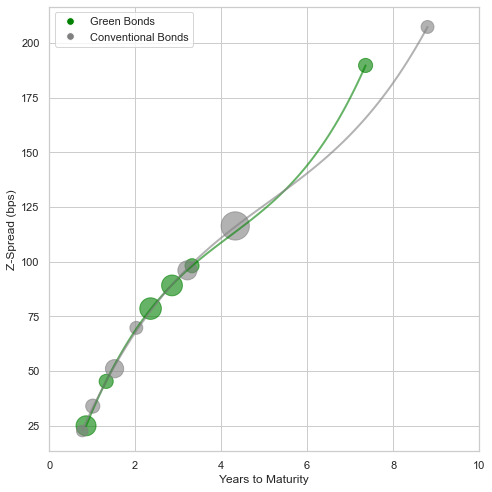

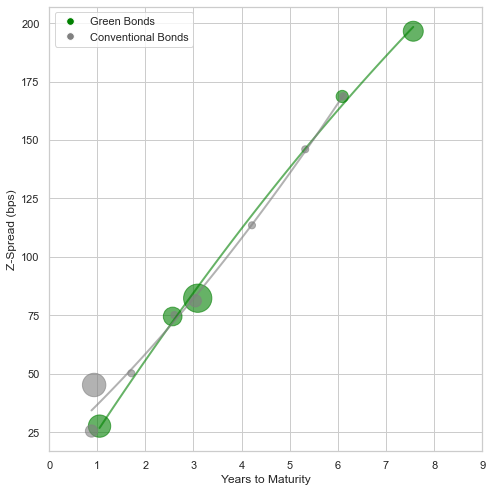

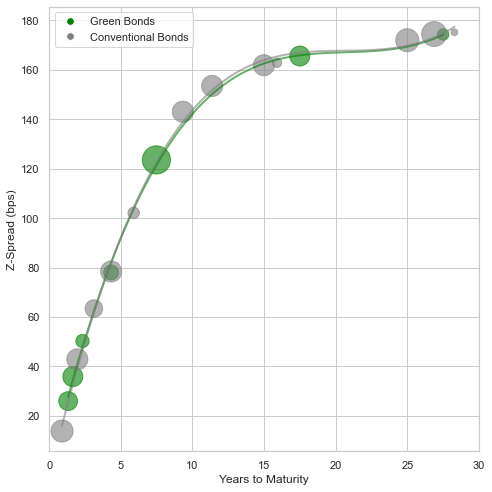

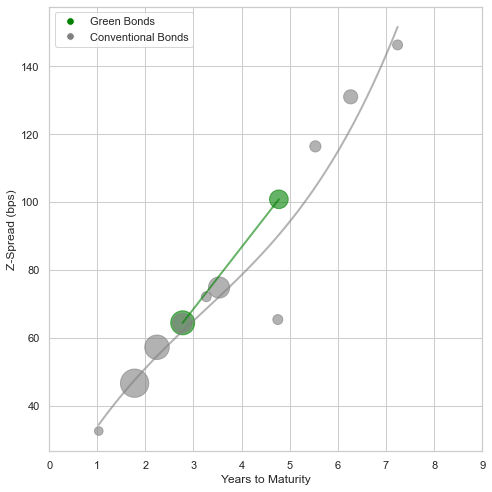

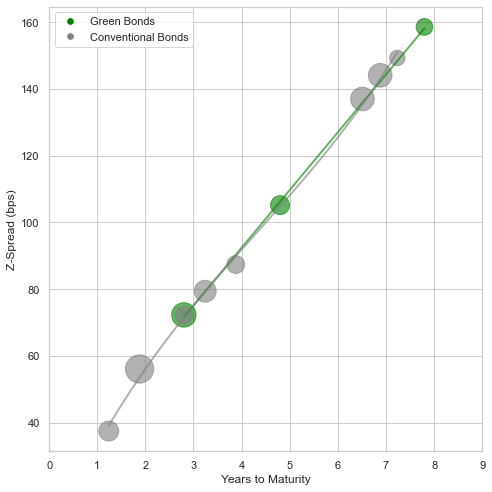

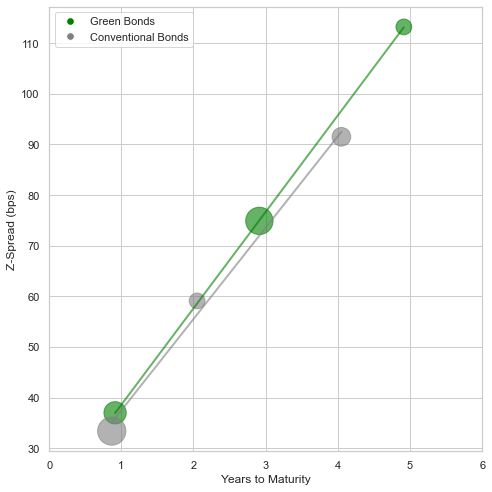

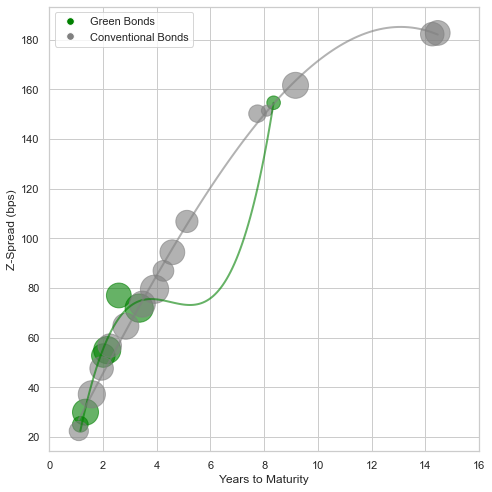

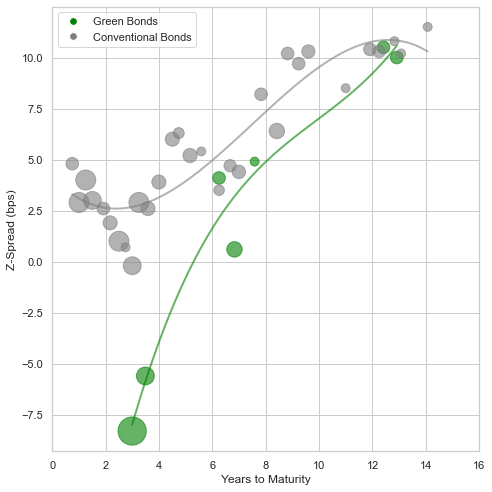

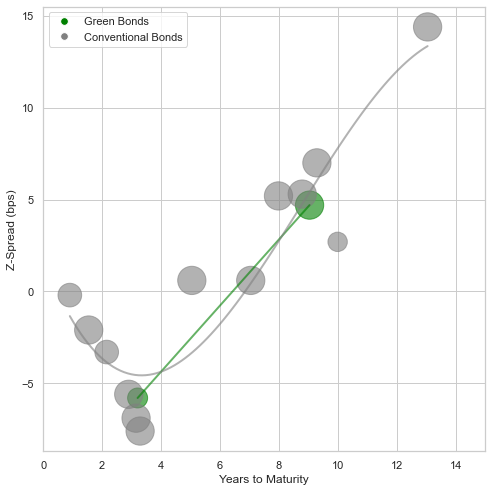

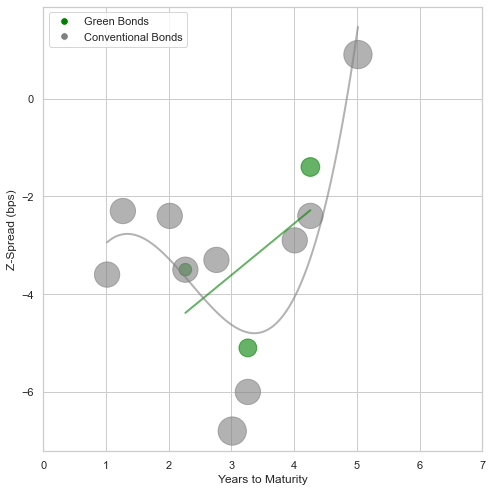

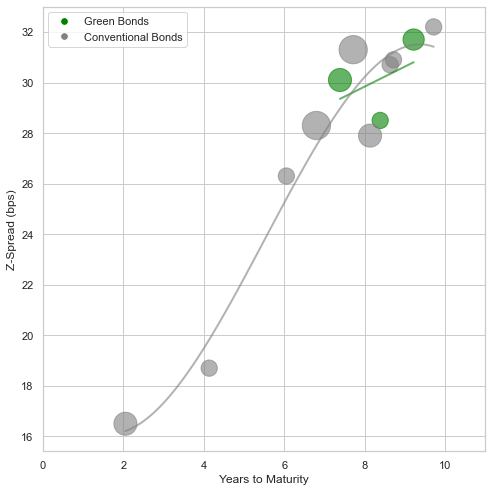

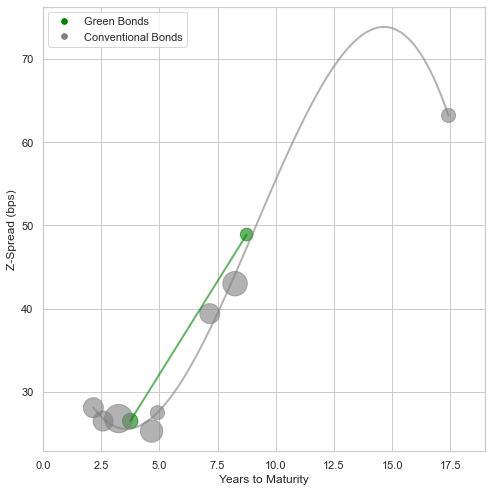

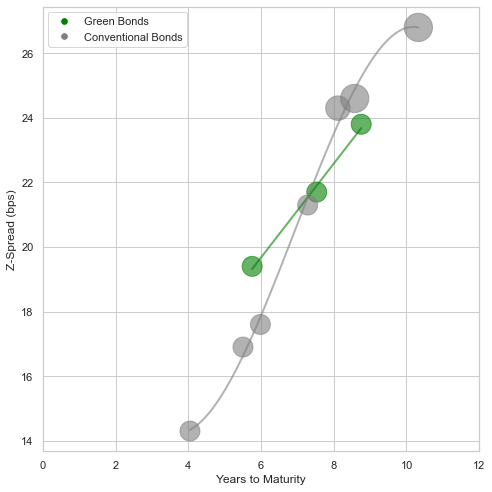

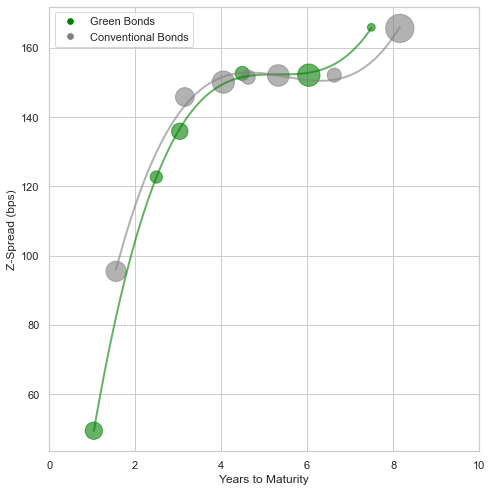

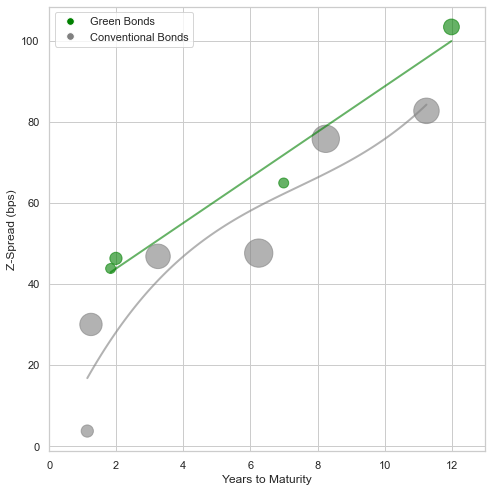

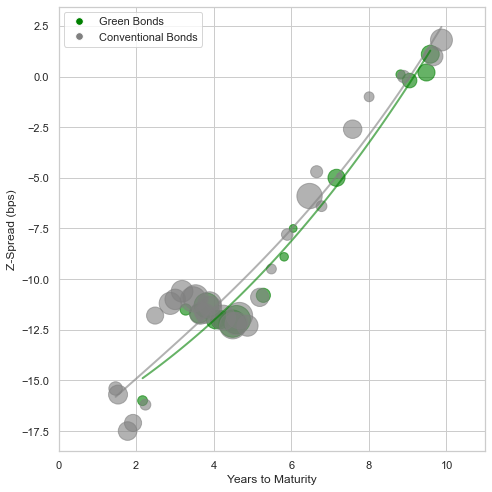

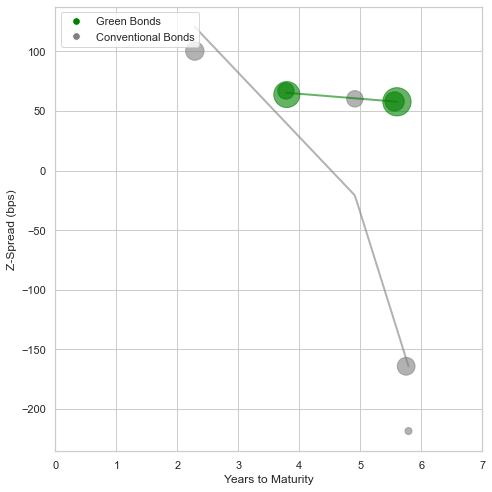

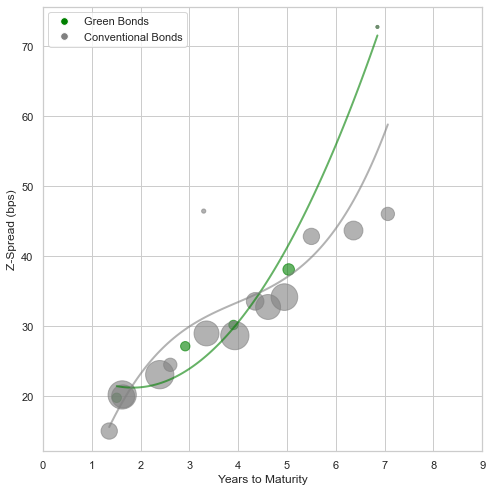

In [299]:
# Get unique company names
unique_companies = bonds['Company'].unique()
greenium = []

# Plot for each company
for company in unique_companies:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    
    # Filter data for the company
    company_bonds = bonds[bonds['Company'] == company]
    
    greenium = interpolate_and_plot(company_bonds, ax, greenium)

    plt.tight_layout()
    plt.savefig(f'../figures/{company}.png', dpi=300)
    plt.show()

In [300]:
company_info = {
    'PNB Merdeka Ventures Sdn Bhd': ['Malaysia', 'Finance', 'Real Estate', '', '', None],
    'Hyundai Card Co Ltd': ['South Korea', 'Finance', 'Banking', 'BBB', '', None],
    'Hyundai Capital Service Inc': ['South Korea', 'Finance', 'Banking', 'BBB+', 'B', None],
    'Korea South-East Power Co Ltd': ['South Korea', 'Utilities', 'Electric Utilities', 'AA', 'B+', None],
    'Hyundai Steel Co': ['South Korea', 'Materials', 'Iron & Steel', 'BBB', 'A-', 85],
    'HD Hyundai Oilbank Co Ltd': ['South Korea', 'Energy', 'Oil & Gas', '', 'C-', 19],
    'Kia Corp':['South Korea', 'Consumer Cyclicals', 'Automobiles', 'BBB+', 'A-', 91,],
    'Korea Western Power Co Ltd	': ['South Korea', 'Utilities', 'Electric Utilities', 'AA', 'B+', None],
    'Incorporated Administrative Japan Housing Finance Agency': ['Japan', 'Government', 'Central Agency', 'A+', '', None],
    'City of Kawasaki': ['Japan', 'Government', 'Municipality', '', 'A-', None],
    'Govt of Kanagawa': ['Japan', 'Government', 'Municipality', '', '', None],
    'Electric Power Deveopment Co Ltd': ['Japan', 'Utilities', 'Electric Utilities', 'A', 'B-', 48],
    'Jera Co Inc': ['Japan', 'Utilities', 'Electric Utilities', 'A-', '', None],
    'Tokyo Gas': ['Japan', 'Utilities', 'Natural Gas Utilities', 'AA-', 'B+', 68],
    'BTS Group Holdings Pcl': ['Thailand', 'Industrials', 'Transportation', 'A-', 'A-', 61],
    'Global Power Synergy Pcl': ['Thailand', 'Utilities', 'Electric Utilities', 'BBB-', 'B-', 46],
    'TSMC': ['Taiwan', 'Technology', 'Semiconductors', 'AA-', 'A-', 73],
    'Indian Renewable Energy Development Agency	': ['India', 'Finance', 'Banking', 'BBB-', '', None],
    'Asian Development Bank': ['Philippines', 'Government', 'IO', 'AAA', '', None]
}

In [301]:
df_info = pd.DataFrame.from_dict(company_info, orient = 'index').reset_index()
df_info.columns = ['company', 'country', 'industry', 'subindustry', 'rating', 'esg', 'environ']

In [285]:
df_greenium = pd.DataFrame(greenium, columns=['id', 'country', 'company', 'coupon', 'greenium-z'])
df_greenium

,id,country,company,coupon,greenium-z
0,MYSUK190304=RRPS,Malaysia,PNB Merdeka Ventures Sdn Bhd,4.64,15.310577
1,MYSUK190305=RRPS,Malaysia,PNB Merdeka Ventures Sdn Bhd,4.68,15.679489
2,MYSUK190306=RRPS,Malaysia,PNB Merdeka Ventures Sdn Bhd,4.73,15.081736
3,MYSUK210245=RRPS,Malaysia,PNB Merdeka Ventures Sdn Bhd,4.85,15.512385
4,MYSUK190307=RRPS,Malaysia,PNB Merdeka Ventures Sdn Bhd,4.78,15.510178
...,...,...,...,...,...
83,045167CY7=RRPS,Philippines,Asian Development Bank,2.215,2.071319
84,045167DR1=RRPS,Philippines,Asian Development Bank,1.75,-2.413382
85,045167EC3=RRPS,Philippines,Asian Development Bank,2.375,-2.985558
86,045167EJ8=RRPS,Philippines,Asian Development Bank,3.125,0.925077


In [290]:
df_greenium_agg = df_greenium.groupby('company')['greenium-z'].agg(['mean', 'max', 'min'])
df_greenium_agg = pd.merge(df_greenium_agg, df_info, on = 'company')
df_greenium_agg = df_greenium_agg.sort_values(by = ['country', 'industry'])

In [291]:
df_greenium_agg

,company,mean,max,min,country,industry,subindustry,rating,esg,environ
2,City of Kawasaki,-0.972132,-0.703671,-1.240593,Japan,Government,Municipality,,A-,NaN
5,Govt of Kanagawa,0.566736,1.863146,-0.315695,Japan,Government,Municipality,,,NaN
10,Incorporated Administrative Japan Housing Fina...,-4.150595,-0.354357,-10.981123,Japan,Government,Central Agency,A+,,NaN
3,Electric Power Deveopment Co Ltd,-0.327261,1.130931,-2.319002,Japan,Utilities,Electric Utilities,A,B-,48.0
11,Jera Co Inc,1.235908,1.565141,0.906675,Japan,Utilities,Electric Utilities,A-,,NaN
16,Tokyo Gas,0.054907,2.157872,-1.457629,Japan,Utilities,Natural Gas Utilities,AA-,B+,68.0
14,PNB Merdeka Ventures Sdn Bhd,15.418873,15.679489,15.081736,Malaysia,Finance,Real Estate,,,NaN
0,Asian Development Bank,3.060047,17.702781,-2.985558,Philippines,Government,IO,AAA,,NaN
12,Kia Corp,1.995181,2.910643,1.079718,South Korea,Consumer Cyclicals,Automobiles,BBB+,A-,91.0
6,HD Hyundai Oilbank Co Ltd,0.576634,0.774632,0.378636,South Korea,Energy,Oil & Gas,,C-,19.0


In [292]:
latex_code = df_greenium_agg[['company', 'country', 'industry', 'rating', 'esg', 'min', 'mean', 'max']].to_latex(index=False)

In [293]:
latex_code

'\\begin{tabular}{lllllrrr}\n\\toprule\ncompany & country & industry & rating & esg & min & mean & max \\\\\n\\midrule\nCity of Kawasaki & Japan & Government &  & A- & -1.240593 & -0.972132 & -0.703671 \\\\\nGovt of Kanagawa & Japan & Government &  &  & -0.315695 & 0.566736 & 1.863146 \\\\\nIncorporated Administrative Japan Housing Finance Agency & Japan & Government & A+ &  & -10.981123 & -4.150595 & -0.354357 \\\\\nElectric Power Deveopment Co Ltd & Japan & Utilities & A & B- & -2.319002 & -0.327261 & 1.130931 \\\\\nJera Co Inc & Japan & Utilities & A- &  & 0.906675 & 1.235908 & 1.565141 \\\\\nTokyo Gas & Japan & Utilities & AA- & B+ & -1.457629 & 0.054907 & 2.157872 \\\\\nPNB Merdeka Ventures Sdn Bhd & Malaysia & Finance &  &  & 15.081736 & 15.418873 & 15.679489 \\\\\nAsian Development Bank & Philippines & Government & AAA &  & -2.985558 & 3.060047 & 17.702781 \\\\\nKia Corp & South Korea & Consumer Cyclicals & BBB+ & A- & 1.079718 & 1.995181 & 2.910643 \\\\\nHD Hyundai Oilbank Co L